# 0. Определяю свою LogReg

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

In [2]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    if batch_size > X.shape[0]:
        batch_size = X.shape[0]
    if shuffle:
        new_ids = np.random.permutation(X.shape[0])
    else:
        new_ids = np.arange(X.shape[0])
    number_batches = X.shape[0] // batch_size
    for i in range(number_batches):
        indices = range(batch_size*i, batch_size*(i+1))
        X_batch = X[new_ids[indices]]
        y_batch = y[new_ids[indices]]
        yield (X_batch, y_batch)
    if len(X) % batch_size != 0:
        indices = batch_size*(i+1)
        X_batch = X[new_ids[indices:]]
        y_batch = y[new_ids[indices:]]
        yield (X_batch, y_batch)

In [3]:
def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    sigm_value_x = 1/(1 + np.exp(-(x)))
    return sigm_value_x


class MySGDClassifier(BaseEstimator, ClassifierMixin):   
    def __init__(self, batch_generator, batch_size=50, \
                 C=1, alpha=0.01, max_epoch=10, model_type='log_reg', th=0.5):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.th = th
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        self.weights = []
        self.batch_size = batch_size
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        loss = 0.
        if self.model_type == 'lin_reg':
            for x, y in zip(X_batch, y_batch):
                a = np.dot(x, self.weights)
                loss += (a-y)**2
            loss /= len(y_batch)
            loss += np.dot(self.weights[1:], self.weights[1:]) / self.C
        elif self.model_type == 'log_reg':
            for x, y in zip(X_batch, y_batch):
                a = sigmoid(np.dot(x, self.weights))
                temp = a**y * (1-a)**(1-y)
                if temp < 10**(-301):                       # наугад
                    loss -= -1000                          # наугад
                    continue
                loss -= np.log2(temp)
#                 loss -= y * np.log2(a) + (1-y) * np.log2(1-a)
            loss /= len(y_batch)
            loss += np.dot(self.weights[1:], self.weights[1:]) / self.C
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """      
        loss_grad = 0.
        if self.model_type == 'lin_reg':
            for x, y in zip(X_batch, y_batch):
                a = np.dot(x, self.weights)
                loss_grad += (a-y)*x
            loss_grad /= len(y_batch)
            R = self.weights / self.C
            R[0] = 0
            loss_grad += R
        elif self.model_type == 'log_reg':
            for x, y in zip(X_batch, y_batch):
                dot = np.dot(x, self.weights)
                a = sigmoid(dot)
                loss_grad += (a-y)*x
            loss_grad /= len(y_batch)
            R = self.weights / self.C
            R[0] = 0
            loss_grad += R
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """    
        alpha_k = self.alpha / self.curr_epoch**(0.005)
        self.weights = self.weights - alpha_k * new_grad
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''    
        if self.model_type == 'lin_reg':
            y = y - np.mean(y)
        X = np.hstack((np.ones((X.shape[0],1)), X))
        self.weights = X[np.random.randint(0, X.shape[0]-1)]
        self.curr_epoch = 0
        for n in range(0, self.max_epoch):
            self.curr_epoch += 1
            new_epoch_generator = self.batch_generator(X, y, shuffle=True, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)  
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''        
        X = np.hstack((np.ones((X.shape[0],1)), X))
        y_hat = np.array([])        
        if self.model_type == 'lin_reg':
            y_hat = np.dot(X, self.weights) / np.sum(X)
        elif self.model_type == 'log_reg':
            dot_func = lambda x: True if (sigmoid(np.dot(x, self.weights)) - self.th > 0) else False
            y_hat = np.apply_along_axis(dot_func, 1, X).astype(int)
        return y_hat

In [4]:
# я написал свой StratifiedKFold ))
from sklearn.metrics import f1_score

def kfold_generator(groups_train, n_splits=10):
    all_groups = np.unique(groups_train)
    fold_size = len(all_groups) // n_splits
    all_groups = np.random.permutation(all_groups)
    fold_groups = np.zeros((n_splits,fold_size), dtype=int)
    for i, group in enumerate(all_groups):
        fold = i // fold_size
        if fold == n_splits:
            break
        group_i = i % fold_size
        fold_groups[fold,group_i] = group
    fold_indices = {}
    for fold in range(n_splits):
        indices = np.array([], dtype = int)
        for group in fold_groups[fold]:
            indices = np.append(indices, np.argwhere(groups_train == group))
        fold_indices[fold] = indices

    for i in fold_indices:
        kf_test = fold_indices[i]
        kf_train = np.array([],dtype=int)
        for j in fold_indices:
            if i == j:
                continue
            kf_train = np.append(kf_train, fold_indices[j])
        kf_tuple = [kf_train, kf_test]
        yield (kf_train, kf_test)
        
def cross_validation(model, groups_train, kfold_generator, X, y, folds=10, verbose=False):    
    total_score = 0
    for i, tuple_indices in enumerate(kfold_generator(groups_train, n_splits=folds)):
        train_index, test_index = tuple_indices
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if model.model_type == 'lin_reg':
            score = f1_score(y_test, np.around(y_pred).astype(int).astype(bool))
        else:
            score = f1_score(y_test, y_pred)
        total_score += score
        if verbose:
            print(i, "score:", f1_score(y_test, y_pred))
    mean_score = total_score / folds
    if verbose:
        print("MEAN_SCORE:", mean_score)
    return mean_score

def grid_cv(alpha_list, C_list, max_epoch_list, th_list, 
            X, y, groups_train, kfold_generator, batch_generator, 
            model_type='log_reg', folds=10, repeats=1, verbose=True):
    sample_scores = np.array([])
    sample_params = []
    for alpha in alpha_list:
        for C in C_list:
            for max_epoch in max_epoch_list:
                for th in th_list: 
                    curr_mean_score_list = np.array([])
                    for r in range(repeats):
                        model = MySGDClassifier(batch_generator=batch_generator, model_type=model_type, 
                                                alpha=alpha, C=C, th=th, max_epoch=max_epoch)
                        curr_score = cross_validation(model, groups_train, kfold_generator, X, y, folds=folds)
                        curr_mean_score_list = np.append(curr_mean_score_list, curr_score)
                    curr_mean_score = curr_mean_score_list.mean()
                    sample_scores = np.append(sample_scores, curr_mean_score)
                    sample_tuple = (alpha, C, th, max_epoch)
                    sample_params.append(sample_tuple)
                    if verbose:
                        print("SCORE: ", curr_mean_score, end='\t\t')
                        print("(alpha = %s; C = %s; max_epoch = %s; th = %s)" % (alpha, C, max_epoch, th))
    best_score_index = np.argmax(sample_scores)
    best_score = sample_scores[best_score_index]
    best_params = sample_params[best_score_index]
    if verbose:
        print("\nBEST SCORE:\t", best_score)
        print("BEST PARAMS:\t", best_params)
    return best_score, best_params, sample_scores, sample_params

Всё ок?

weights to lin_reg: [-0.69671267  0.13956355 -0.17903819]
weights to log_reg: [-4.49808372  0.95993037 -1.05398791]


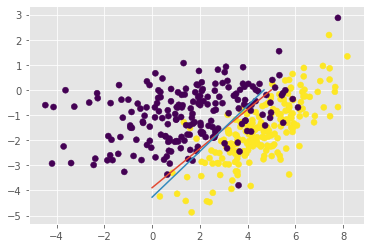

In [5]:
def plot_decision_boundary(clf):
    x_1 = 0
    x_2 = - clf.weights[0] / clf.weights[1]
    f_0 = [x_1, x_2]
    
    x_1 = - clf.weights[0] / clf.weights[2]
    x_2 = 0
    f_1 = [x_1, x_2]

    plt.plot(f_0, f_1)
    
np.random.seed(1)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
        
lin_reg = MySGDClassifier(batch_generator=batch_generator, model_type='lin_reg', alpha=0.05, C=100, max_epoch=100)
lin_reg.fit(X,y)
plot_decision_boundary(lin_reg)
print("weights to lin_reg:", lin_reg.weights)

log_reg = MySGDClassifier(batch_generator=batch_generator, model_type='log_reg', alpha=0.05, C=100, max_epoch=250)
log_reg.fit(X,y)
plot_decision_boundary(log_reg)
print("weights to log_reg:", log_reg.weights)

plt.scatter(X[:,0], X[:,1], c=y)

# 1. Предобработка данных

Считываем из файла 'docs_titles.tsv' все заголовки train и test. И удаляем из заголовков слова с длиной <= 2 символа.

In [6]:
# просто переписал код из второй домашки в виде функций
import re

def preprocessing_1(useful_words_tsv, min_length=0):
    doc_to_title = {}
    with open(useful_words_tsv) as f:
        for num_line, line in enumerate(f):
            if num_line == 0:
                continue
            data = line.strip().split('\t', 1)
            doc_id = int(data[0])
            if len(data) == 1:
                title = ''
            else:
                title = data[1]
#           магические 5 строчек!---------
            cur = re.split(r' ',title)
            title = ''
            for i in cur:
                if len(i) >= min_length:
                    title += i + ' '
#           ------------------------------          
            doc_to_title[doc_id] = title
    return doc_to_title

Считывание train'a. Результат группируется в traingroups_titledata - словарь с ключом group_id

In [7]:
def preprocessing_2(train_or_test_groups_csv, doc_to_title, train=True):
    train_data = pd.read_csv(train_or_test_groups_csv)
    traingroups_titledata = {}
    for i in range(len(train_data)):
        new_doc = train_data.iloc[i]
        doc_group = new_doc['group_id']
        doc_id = new_doc['doc_id']
        title = doc_to_title[doc_id]
        if doc_group not in traingroups_titledata:
            traingroups_titledata[doc_group] = []
        if train:
            target = new_doc['target']
            traingroups_titledata[doc_group].append((doc_id, title, target))
        else:
            traingroups_titledata[doc_group].append((doc_id, title))
    return traingroups_titledata

Формирование 15 признаков: <br> 
признак №1 - число пересечений множества слов текущего заголовка с множеством слов другого (максимально похожего) заголовка из этой группы;<br>
... <br>
признак №15 - число пересечений множества слов текущего заголовка с множеством слов другого (сильно похожего, но на 15-ом месте по похожести) заголовка из этой группы.

In [8]:
def preprocessing_3(traingroups_titledata, num_features=15, train=True):
    y_train = []
    X_train = []
    groups_train = []
    for new_group in traingroups_titledata:
        docs = traingroups_titledata[new_group] 
        for k, tup in enumerate(docs):
            if train:
                doc_id, title, target_id = tup
                y_train.append(target_id)
            else:
                doc_id, title = tup
            groups_train.append(new_group)
            all_dist = []
            words = set(title.strip().split())
            for j in range(0, len(docs)):
                if k == j:
                    continue
                if train:
                    doc_id_j, title_j, target_j = docs[j]
                else:
                    doc_id_j, title_j = docs[j]
                words_j = set(title_j.strip().split())
                all_dist.append(len(words.intersection(words_j)))
            X_train.append(sorted(all_dist, reverse=True)[0:num_features])
    if train:
        return np.array(X_train), np.array(y_train), np.array(groups_train)
    else:
        return np.array(X_train), np.array([]), np.array(groups_train)

In [9]:
def preprocessing(useful_words_tsv, train_or_test_groups_csv, min_length, num_features, train=True):
    doc_to_title = preprocessing_1(useful_words_tsv, min_length=min_length)
    traingroups_titledata = preprocessing_2(train_or_test_groups_csv, doc_to_title, train=train)
    X_train, y_train, groups_train = preprocessing_3(traingroups_titledata, num_features=num_features, train=train)
    return X_train, y_train, groups_train

### Старые фичи

In [10]:
useful_words_tsv = 'docs_titles.tsv'
train_or_test_groups_csv = 'train_groups.csv'
min_length = 3
num_features = 20

X_train, y_train, groups_train = preprocessing(useful_words_tsv, train_or_test_groups_csv, \
                                              min_length=min_length, num_features=num_features) 
print(X_train.shape, y_train.shape, groups_train.shape)

(11690, 20) (11690,) (11690,)


### Признаки из url.

In [11]:
useful_words_tsv = 'improved_useful_names.csv'
train_or_test_groups_csv = 'train_groups.csv'
min_length = 0
num_features = 5

X_train_addition, _, _ = preprocessing(useful_words_tsv, train_or_test_groups_csv, \
                                              min_length=min_length, num_features=num_features) 
print(X_train_addition.shape)

(11690, 5)


In [12]:
X_train = np.hstack((X_train, X_train_addition))
X_train.shape

(11690, 25)

### Настины фичи

In [13]:
import pymorphy2  # $ pip install pymorphy2
  
def pos(word, morth=pymorphy2.MorphAnalyzer()):
    "Return a likely part of speech for the *word*."""
    return morth.parse(word)[0].tag.POS
  
words = "Однако я так и не смог закончить".split()
functors_pos = {'INTJ', 'PRCL', 'CONJ', 'PREP'} 

In [14]:
import re
doc_to_title = {}
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        r = [ i.lower() for i in re.split(r'\W+',title) if i]
        p = [re.sub(r'[^А-я]', '', i) for i in r]
        p1 = list(filter(lambda i: i, p))
        cur = [word for word in p1 if (pos(word) not in functors_pos and len(word)>1)]
        cur = [morph.parse(o)[0].normal_form for o in cur]
        title = ''
        for i in cur:
            if len(i)>2:
                title += i + ' '        
        doc_to_title[doc_id] = title

In [15]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [16]:
import numpy as np
# y_train = []
X_train_addition = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
#         y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        sum1 = 0
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            y = len(words.intersection(words_j))
            all_dist.append(y)
            sum1+=y
        X_train_addition.append([sum1])
X_train_addition = np.array(X_train_addition)
# y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train_addition.shape)

(11690, 1)


In [17]:
X_train = np.hstack((X_train, X_train_addition))
X_train.shape

(11690, 26)

### Масштабирование признаков
$f := \frac{f - mean}{std}$

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)

# 2. Подбор параметров

In [19]:
alpha_list = [0.1]
C_list = [500]
max_epoch_list = [8]
th_list = [0.26, 0.27, 0.28]

best_score, _, sample_scores, _ = grid_cv(alpha_list, C_list, max_epoch_list, th_list, 
                                    X_train_scale, y_train, groups_train, kfold_generator, batch_generator, 
                                    model_type='log_reg', folds=3, repeats=32, verbose=True)

SCORE:  0.6957452623647534		(alpha = 0.1; C = 500; max_epoch = 8; th = 0.26)
SCORE:  0.6951674714316782		(alpha = 0.1; C = 500; max_epoch = 8; th = 0.27)
SCORE:  0.6940748428639563		(alpha = 0.1; C = 500; max_epoch = 8; th = 0.28)

BEST SCORE:	 0.6957452623647534
BEST PARAMS:	 (0.1, 500, 0.26, 8)


# 3. Test predict

In [20]:
def write_to_submission_file(predicted_labels, test_groups_csv, out_file, target='target', index_label="pair_id"):
    indices = np.asarray(pd.read_csv(test_groups_csv)[index_label])
    predicted_df = pd.DataFrame(predicted_labels, index = indices, columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [21]:
useful_words_tsv = 'docs_titles.tsv'
train_or_test_groups_csv = 'test_groups.csv'
min_length = 3
num_features = 20

X_test, _, _ = preprocessing(useful_words_tsv, train_or_test_groups_csv, \
                          min_length=min_length, num_features=num_features, train=False) 
print(X_test.shape)

(16627, 20)


In [22]:
useful_words_tsv = 'useful_names.txt' # это неправильный файл!
train_or_test_groups_csv = 'test_groups.csv'
min_length = 3
num_features = 5

X_test_addition, _, _ = preprocessing(useful_words_tsv, train_or_test_groups_csv, \
                          min_length=min_length, num_features=num_features, train=False) 
print(X_test_addition.shape)

(16627, 5)


In [23]:
X_test = np.hstack((X_test, X_test_addition))
X_test.shape

(16627, 25)

In [24]:
import pymorphy2  # $ pip install pymorphy2
  
def pos(word, morth=pymorphy2.MorphAnalyzer()):
    "Return a likely part of speech for the *word*."""
    return morth.parse(word)[0].tag.POS
  
words = "Однако я так и не смог закончить".split()
functors_pos = {'INTJ', 'PRCL', 'CONJ', 'PREP'} 


import re
doc_to_title = {}
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        r = [ i.lower() for i in re.split(r'\W+',title) if i]
        p = [re.sub(r'[^А-я]', '', i) for i in r]
        p1 = list(filter(lambda i: i, p))
        cur = [word for word in p1 if (pos(word) not in functors_pos and len(word)>1)]
        cur = [morph.parse(o)[0].normal_form for o in cur]
        title = ''
        for i in cur:
            if len(i)>2:
                title += i + ' '
#         print(title)
        
        doc_to_title[doc_id] = title
# print (len(doc_to_title))



# import pandas as pd
test_data = pd.read_csv('test_groups.csv')
test_groups_titledata = {}
for i in range(len(test_data)):
    new_doc1 = test_data.iloc[i]
    doc_group1 = new_doc1['group_id']
    doc_id1 = new_doc1['doc_id']
    title1 = doc_to_title[doc_id1]
    if doc_group1 not in test_groups_titledata:
        test_groups_titledata[doc_group1] = []
    test_groups_titledata[doc_group1].append((doc_id1, title1))
X_test_addition = []
groups_test = []
for new_group in test_groups_titledata:
    docs1 = test_groups_titledata[new_group]
    for k, (doc_id, title) in enumerate(docs1):
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        sum1 = 0
        for j in range(0, len(docs1)):
            if k == j:
                continue
            doc_id_j, title_j= docs1[j]
            words_j = set(title_j.strip().split())
            y = len(words.intersection(words_j))
            all_dist.append(y)
            sum1+=y
#             all_dist.append(len(words.intersection(words_j)))
        X_test_addition.append([sum1])
X_test_addition = np.array(X_test_addition)
groups_test = np.array(groups_test)
print (X_test_addition.shape, groups_test.shape)

(16627, 1) (16627,)


In [25]:
X_test = np.hstack((X_test, X_test_addition))
X_test.shape

(16627, 26)

In [26]:
scaler = StandardScaler()
scaler.fit(X_test)
X_test_scale = scaler.transform(X_test)

In [28]:
log_reg = MySGDClassifier(batch_generator=batch_generator, model_type='log_reg', \
#                             alpha=0.1, C=500, th=0.26, max_epoch=8)  # 15 старых + 5 новых (хардкор) - 0.65666
#                             alpha=0.1, C=500, th=0.26, max_epoch=10) # 5 новых фич (менее хардкорно) - 0.65450
#                             alpha=0.1, C=500, th=0.26, max_epoch=10) # (+) настины фичи - 0.68670
                            alpha=0.1, C=500, th=0.26, max_epoch=10)   # тоже самое, но 20 старых фич - 0.68900
log_reg.fit(X_train_scale, y_train)
y_pred = log_reg.predict(X_test_scale)
write_to_submission_file(y_pred, 'test_groups.csv', "y_pred.csv")